# Demo of a KDE plot beside timeseries set

In [1]:
%pylab inline
#%matplotlib inline
#import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
#mpld3.enable_notebook()
#%matplotlib notebook
#
import pysd
import numpy as np
import pandas as pd
import seaborn

Populating the interactive namespace from numpy and matplotlib


### Load the model using PySD
The model is a basic, 1-stock carbon bathtub model

In [2]:
model = pysd.read_vensim('../../models/Climate/Atmospheric_Bathtub.mdl')
print(model.doc)

                   Real Name                    Py Name Subscripts  Units  \
0                  Emissions                  emissions       None   None   
1  Excess Atmospheric Carbon  excess_atmospheric_carbon       None   None   
2                 FINAL TIME                 final_time       None  Month   
3               INITIAL TIME               initial_time       None  Month   
4            Natural Removal            natural_removal       None   None   
5           Removal Constant           removal_constant       None   None   
6                    SAVEPER                    saveper       None  Month   
7                  TIME STEP                  time_step       None  Month   
8                       Time                       time       None   None   

       Limits       Type Subtype                                     Comment  
0  (nan, nan)   Constant  Normal                                        None  
1  (nan, nan)   Stateful   Integ                                       

### Generate a set of parameters to use as input
Here, drawing 100 constant values for the `Emissions` parameter from an exponential distribution

In [3]:
n_runs = 100
runs = pd.DataFrame({'Emissions': np.random.exponential(scale=10000, size=n_runs)})
runs.head()

,Emissions
0,10518.721209
1,259.030043
2,9370.886007
3,1969.074553
4,951.741080


### Run the model with the various parameters

In [4]:
result = runs.apply(lambda p: model.run(params=dict(p))['Excess Atmospheric Carbon'],
                    axis=1).T
result.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10518.721209,259.030043,9370.886007,1969.074553,951.741080,2667.249424,4312.736439,29400.288812,1881.874878,4136.830444,...,33705.518832,16488.662222,13194.408440,1124.352826,2025.199870,4715.830752,29767.096801,5037.719429,6059.311181,1834.413835
2,20932.255207,515.469785,18648.063154,3918.458360,1893.964750,5307.826353,8582.345513,58506.574736,3744.931008,8232.292583,...,67073.982477,32812.437822,26256.872795,2237.462125,4030.147741,9384.503197,59236.522633,10025.061664,12058.029250,3650.483532
3,31241.653864,769.345130,27832.468530,5848.348330,2826.766182,7921.997514,12809.258496,87321.797801,5589.356576,12286.800101,...,100108.761484,48972.975666,39188.712506,3339.440330,6015.046134,14006.488918,88411.254207,14962.530477,17996.760139,5448.392532
4,41447.958535,1020.681722,36925.029851,7758.939399,3750.239601,10510.026962,16993.902350,115848.868635,7415.337889,16300.762544,...,132813.192702,64971.908131,51991.233821,4430.398753,7980.095543,18582.254781,117294.238466,19850.624601,23876.103718,7228.322441


### Draw a static plot showing the results, and a marginal density plot
This would be for making graphics for a publication, where you don't want an interactive view, but you want fine control over what the figure looks like.

This is relatively simple, because we rely on the plotting library `seaborn` to generate the KDE plot, instead of working out the densities ourselves.

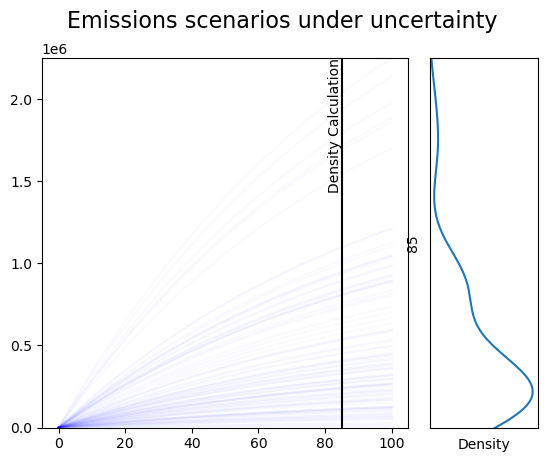

In [5]:
import matplotlib.pylab as plt
# define when to show the density
density_time = 85

# left side: plot all traces, slightly transparent
plt.subplot2grid((1,4), loc=(0,0), colspan=3)
[plt.plot(result.index, result[i], 'b', alpha=.02) for i in result.columns]
ymax = result.max().max()
plt.ylim(0, ymax)

# left side: add marker of density location
plt.vlines(density_time, 0, ymax, 'k')
plt.text(density_time, ymax, 'Density Calculation', ha='right', va='top', rotation=90)

# right side: gaussian KDE on selected timestamp
plt.subplot2grid((1,4), loc=(0,3))
seaborn.kdeplot(y=result.loc[density_time])
plt.ylim(0, ymax)
plt.yticks([])
plt.xticks([])
plt.xlabel('Density')

plt.suptitle('Emissions scenarios under uncertainty', fontsize=16);

### Interactive plot using python backend
The following would be for lightweight exploration 

In [6]:
import matplotlib as mpl
from ipywidgets import interact, IntSlider
sim_time = 200
slider_time = IntSlider(description = 'Select Time for plotting Density',
                        min=0, max=result.index[-1], value=1)

In [11]:
@interact(density_time=slider_time)
def update(density_time): 
    ax1 = plt.subplot2grid((1,4), loc=(0,0), colspan=3)
    [ax1.plot(result.index, result[i], 'b', alpha=.02) for i in result.columns]
    ymax = result.max().max()
    ax1.set_ylim(0, ymax)

    # left side: add marker of density location
    ax1.vlines(density_time, 0, ymax, 'k')
    ax1.text(density_time, ymax, 'Density Calculation', ha='right', va='top', rotation=90)

    # right side: gaussian KDE on selected timestamp
    ax2 = plt.subplot2grid((1,4), loc=(0,3))
    seaborn.kdeplot(y=result.loc[density_time], ax=ax2)
    ax2.set_ylim(0, ymax)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_xlabel('Density')

    plt.suptitle('Emissions scenarios under uncertainty', fontsize=16);
    

interactive(children=(IntSlider(value=1, description='Select Time for plotting Density'), Output()), _dom_clas…

### Interactive figure with javascript background
This script would prepare interactive graphics to share on a webpage, independent of the python backend. 

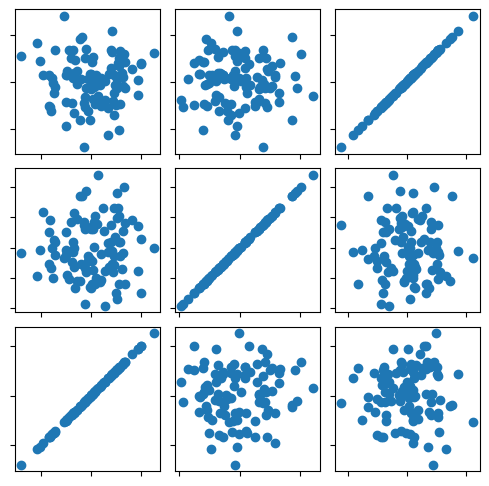

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax[::-1]

X = np.random.normal(size=(3, 100))
for i in range(3):
    for j in range(3):
        ax[i, j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i, j].yaxis.set_major_formatter(plt.NullFormatter())
        points = ax[i, j].scatter(X[j], X[i])
        
plugins.connect(fig, plugins.LinkedBrush(points))